In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

In [2]:
import dtale
from merf import viz
from merf.merf import *
from sklearn import *

In [3]:
import numpy as np
import pandas as pd
import seaborn as seas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import wbgapi as wb
from scipy import stats

seas.set(style="ticks", context="talk")
plt.style.use("dark_background")

In [4]:
indexes = ['EN.ATM.CO2E.KT',        #CO2 emissions (kt)
           'NY.GDP.MKTP.PP.KD',     #GDP per capita, PPP (constant 2017 international $)
           'SP.POP.TOTL',           #Population, total 
           'EG.FEC.RNEW.ZS',        #Renewable energy consumption (% of total final energy
           'SP.URB.TOTL.IN.ZS',     #Urban population (% of total population) 
           'NV.MNF.TECH.ZS.UN',     #Medium and high-tech manufacturing value added (% manufacturing value added)
           'NE.TRD.GNFS.ZS']        #Trade (% of GDP)

In [5]:
countries = ['Argentina',
'Armenia',
'Australia',
'Austria',
'Belgium',
'Bulgaria',
'Belarus',
'Brazil',
'Canada',
'Switzerland',
'Chile',
'China',
'Colombia',
'Czech Republic',
'Germany',
'Denmark',
'Spain',
'Estonia',
'Finland',
'France',
'United Kingdom',
'Georgia',
'Greece',
'Croatia',
'Hungary',
'India',
'Ireland',
'Iceland',
'Israel',
'Italy',
'Japan',
'Kazakhstan',
'Korea, Rep.',
'Lithuania',
'Latvia',
'Moldova',
'Mexico',
'Malaysia',
'Netherlands',
'Norway',
'New Zealand',
'Panama',
'Peru',
'Poland',
'Portugal',
'Romania',
'Russian Federation',
'Singapore',
'Serbia',
'Slovak Republic',
'Slovenia',
'Sweden',
'Turkey',
'Ukraine',
'United States',
'South Africa'] 

In [6]:
countries = [wb.economy.coder(country) for country in countries]

In [7]:
raw_dataset = wb.data.DataFrame(series = indexes, economy = countries, time = range(1994,2023), labels=True,columns='series')

In [8]:
raw_dataset.unstack(0).stack()

Country  Time  EG.FEC.RNEW.ZS  EN.ATM.CO2E.KT  \
time   economy                                                        
YR2021 ZAF       South Africa  2021             NaN             NaN   
       USA      United States  2021             NaN             NaN   
       UKR            Ukraine  2021             NaN             NaN   
       TUR            Turkiye  2021             NaN             NaN   
       SWE             Sweden  2021             NaN             NaN   
...                       ...   ...             ...             ...   
YR1994 BEL            Belgium  1994        0.939573        114900.0   
       AUT            Austria  1994       25.679455         58280.0   
       AUS          Australia  1994        8.259947        280180.0   
       ARM            Armenia  1994       17.763653          2740.0   
       ARG          Argentina  1994       10.734909        111910.0   

                NE.TRD.GNFS.ZS  NV.MNF.TECH.ZS.UN  NY.GDP.MKTP.PP.KD  \
time   economy                                                         
YR2021 ZAF           56.071227                NaN       7.881121e+11   
       USA                 NaN                NaN       2.093228e+13   
       UKR           82.621300                NaN       5.355789e+11   
       TUR           71.212724                NaN       2.657762e+12   
       SWE           88.162017                NaN       5.525622e+11   
...                        ...                ...                ...   
YR1994 BEL          113.232300          14.080100       3.740897e+11   
       AUT           65.987093          36.610757       3.129625e+11   
       AUS           36.458731          27.756124       5.726639e+11   
       ARM          112.429365          28.824233       9.053823e+09   
       ARG           18.134346          29.628354       6.224138e+11   

                SP.POP.TOTL  SP.URB.TOTL.IN.ZS  
time   economy                                  
YR2021 ZAF       60041996.0             67.847  
       USA      331893745.0             82.873  
       UKR       43814581.0             69.757  
       TUR       85042736.0             76.569  
       SWE       10415811.0             88.238  
...                     ...                ...  
YR1994 BEL       10115603.0             96.700  
       AUT        7936118.0             61.870  
       AUS       17855000.0             85.028  
       ARM        3283664.0             66.332  
       ARG       34402669.0             87.960  

[1568 rows x 9 columns]

# Overview

In [9]:
col = ['Number of variables',
'Number of observations',
'Missing cells',
'Missing cells (%)',
'Rows with Missing cells',
'Rows with Missing cells (%)',
'Duplicate rows',
'Duplicate rows (%)']

val = [len(raw_dataset.columns),
len(raw_dataset),
raw_dataset.isna().values.sum(),
(raw_dataset.isna().values.sum()/len(raw_dataset)) * 100,
len(raw_dataset) - len(raw_dataset.dropna()),
((len(raw_dataset)-len(raw_dataset.dropna()))/len(raw_dataset)) * 100,
raw_dataset.duplicated().sum(),
raw_dataset.duplicated().sum()]

val = list(map(round,val))

overview = pd.DataFrame(zip(col,val), columns=['Variables', 'Count'])

In [10]:
overview

,Variables,Count
0,Number of variables,9
1,Number of observations,1568
2,Missing cells,362
3,Missing cells (%),23
4,Rows with Missing cells,125
5,Rows with Missing cells (%),8
6,Duplicate rows,0
7,Duplicate rows (%),0


## Data preprocessing

### Renaming columns for berter readability

In [11]:
raw_dataset = raw_dataset.rename({'EG.FEC.RNEW.ZS': 'Renewable energy consumption',
'EN.ATM.CO2E.KT': 'CO2 emissions',
'NE.TRD.GNFS.ZS': 'Trade (% of GDP)',
'NV.MNF.TECH.ZS.UN': 'Perc Manufacturing Value Added',
'NY.GDP.MKTP.PP.KD': 'GDP per capita',
'SP.POP.TOTL': 'Total Population',
'SP.URB.TOTL.IN.ZS': 'Urban Population',
},axis = 1)

In [12]:
raw_dataset.head()

Country  Time  Renewable energy consumption  \
economy time                                                       
ZAF     YR2021  South Africa  2021                           NaN   
        YR2020  South Africa  2020                           NaN   
        YR2019  South Africa  2019                         10.50   
        YR2018  South Africa  2018                         10.19   
        YR2017  South Africa  2017                         10.45   

                CO2 emissions  Trade (% of GDP)  \
economy time                                      
ZAF     YR2021            NaN         56.071227   
        YR2020            NaN         51.126846   
        YR2019  439640.014648         54.150246   
        YR2018  434350.006104         54.507584   
        YR2017  435649.993896         53.535932   

                Perc Manufacturing Value Added  GDP per capita  \
economy time                                                     
ZAF     YR2021                             NaN    7.881121e+11   
        YR2020                             NaN    7.511939e+11   
        YR2019                       24.428034    8.028319e+11   
        YR2018                       24.428034    8.019253e+11   
        YR2017                       24.428034    7.901706e+11   

                Total Population  Urban Population  
economy time                                        
ZAF     YR2021        60041996.0            67.847  
        YR2020        59308690.0            67.354  
        YR2019        58558267.0            66.856  
        YR2018        57792520.0            66.355  
        YR2017        57009751.0            65.850

### Missing value check


In [13]:
raw_dataset.isna().sum()

Country                             0
Time                                0
Renewable energy consumption      112
CO2 emissions                     112
Trade (% of GDP)                   14
Perc Manufacturing Value Added    112
GDP per capita                     12
Total Population                    0
Urban Population                    0
dtype: int64

In [14]:
raw_dataset = raw_dataset.dropna()

### Outlier detection and treatment

In [15]:
def outlier_treatment(dataset):
    """
    
    Values lying outside 3SD are considered as outliers for this analysis
    Outlier values are treated with mean of that column
    
    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    Dataframe with treated outlier values
    """
    outlier_summary = []

    for col in dataset.columns[2:]:
        outliers = dataset[(np.abs(stats.zscore(dataset[col]))>3)][col]
        outlier_summary.append([col, len(outliers)])
        dataset.loc[outliers.index, col] = dataset[col].mean()

    outlier_summary = pd.DataFrame(outlier_summary, columns=['Variables', 'No. of Outliers'])

    return dataset,outlier_summary

raw_dataset,outlier_summary = outlier_treatment(raw_dataset)

outlier_summary

,Variables,No. of Outliers
0,Renewable energy consumption,14
1,CO2 emissions,43
2,Trade (% of GDP),27
3,Perc Manufacturing Value Added,10
4,GDP per capita,38
5,Total Population,52
6,Urban Population,10


### Calculating Column of Intrest

In [16]:
raw_dataset

Country  Time  Renewable energy consumption  \
economy time                                                       
ZAF     YR2019  South Africa  2019                     10.500000   
        YR2018  South Africa  2018                     10.190000   
        YR2017  South Africa  2017                     10.450000   
        YR2016  South Africa  2016                     10.530000   
        YR2015  South Africa  2015                     10.280000   
...                      ...   ...                           ...   
ARG     YR1998     Argentina  1998                     11.343009   
        YR1997     Argentina  1997                     10.999073   
        YR1996     Argentina  1996                     10.193856   
        YR1995     Argentina  1995                     11.205185   
        YR1994     Argentina  1994                     10.734909   

                CO2 emissions  Trade (% of GDP)  \
economy time                                      
ZAF     YR2019  439640.014648         54.150246   
        YR2018  434350.006104         54.507584   
        YR2017  435649.993896         53.535932   
        YR2016  425140.014648         55.861258   
        YR2015  424809.997559         56.726676   
...                       ...               ...   
ARG     YR1998  132670.000000         23.350028   
        YR1997  126120.000000         23.336179   
        YR1996  122550.000000         21.506468   
        YR1995  112890.000000         19.771423   
        YR1994  111910.000000         18.134346   

                Perc Manufacturing Value Added  GDP per capita  \
economy time                                                     
ZAF     YR2019                       24.428034    8.028319e+11   
        YR2018                       24.428034    8.019253e+11   
        YR2017                       24.428034    7.901706e+11   
        YR2016                       24.428034    7.811255e+11   
        YR2015                       24.428034    7.759688e+11   
...                                        ...             ...   
ARG     YR1998                       30.443321    7.164454e+11   
        YR1997                       30.983214    6.898836e+11   
        YR1996                       28.563551    6.381250e+11   
        YR1995                       27.200513    6.047048e+11   
        YR1994                       29.628354    6.224138e+11   

                Total Population  Urban Population  
economy time                                        
ZAF     YR2019        58558267.0            66.856  
        YR2018        57792520.0            66.355  
        YR2017        57009751.0            65.850  
        YR2016        56207649.0            65.341  
        YR2015        55386369.0            64.828  
...                          ...               ...  
ARG     YR1998        36063451.0            88.759  
        YR1997        35657438.0            88.564  
        YR1996        35246376.0            88.366  
        YR1995        34828168.0            88.164  
        YR1994        34402669.0            87.960  

[1443 rows x 9 columns]

In [17]:
raw_dataset['CO2 per Capita'] = raw_dataset['CO2 emissions']/raw_dataset['Total Population']

### Log Trasforming the data

In [18]:
for col in [col for col in raw_dataset.columns[2:]]:
    raw_dataset[col] = np.log10(raw_dataset[col] + 1)

In [19]:
processed_df = raw_dataset

## Exploratory Data Analysis

### Data Summary


In [20]:
processed_df.describe(include='all')

,Country,Time,Renewable energy consumption,CO2 emissions,Trade (% of GDP),Perc Manufacturing Value Added,GDP per capita,Total Population,Urban Population,CO2 per Capita
count,1443,1443,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000
unique,56,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,South Africa,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,26,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.115691,4.949772,1.863056,1.509789,11.571755,7.179238,1.853878,0.003108
std,NaN,NaN,0.391837,0.672622,0.218728,0.231886,0.640809,0.607142,0.090003,0.002062
min,NaN,NaN,0.123852,3.212454,1.158007,0.690589,9.954466,5.427273,1.475715,0.000323
25%,NaN,NaN,0.867761,4.583097,1.733932,1.405031,11.180345,6.721371,1.797787,0.001783
50%,NaN,NaN,1.148911,4.843239,1.866179,1.569113,11.572287,7.035915,1.872180,0.002858
75%,NaN,NaN,1.445530,5.525500,2.014420,1.674872,12.087101,7.675878,1.916499,0.003929


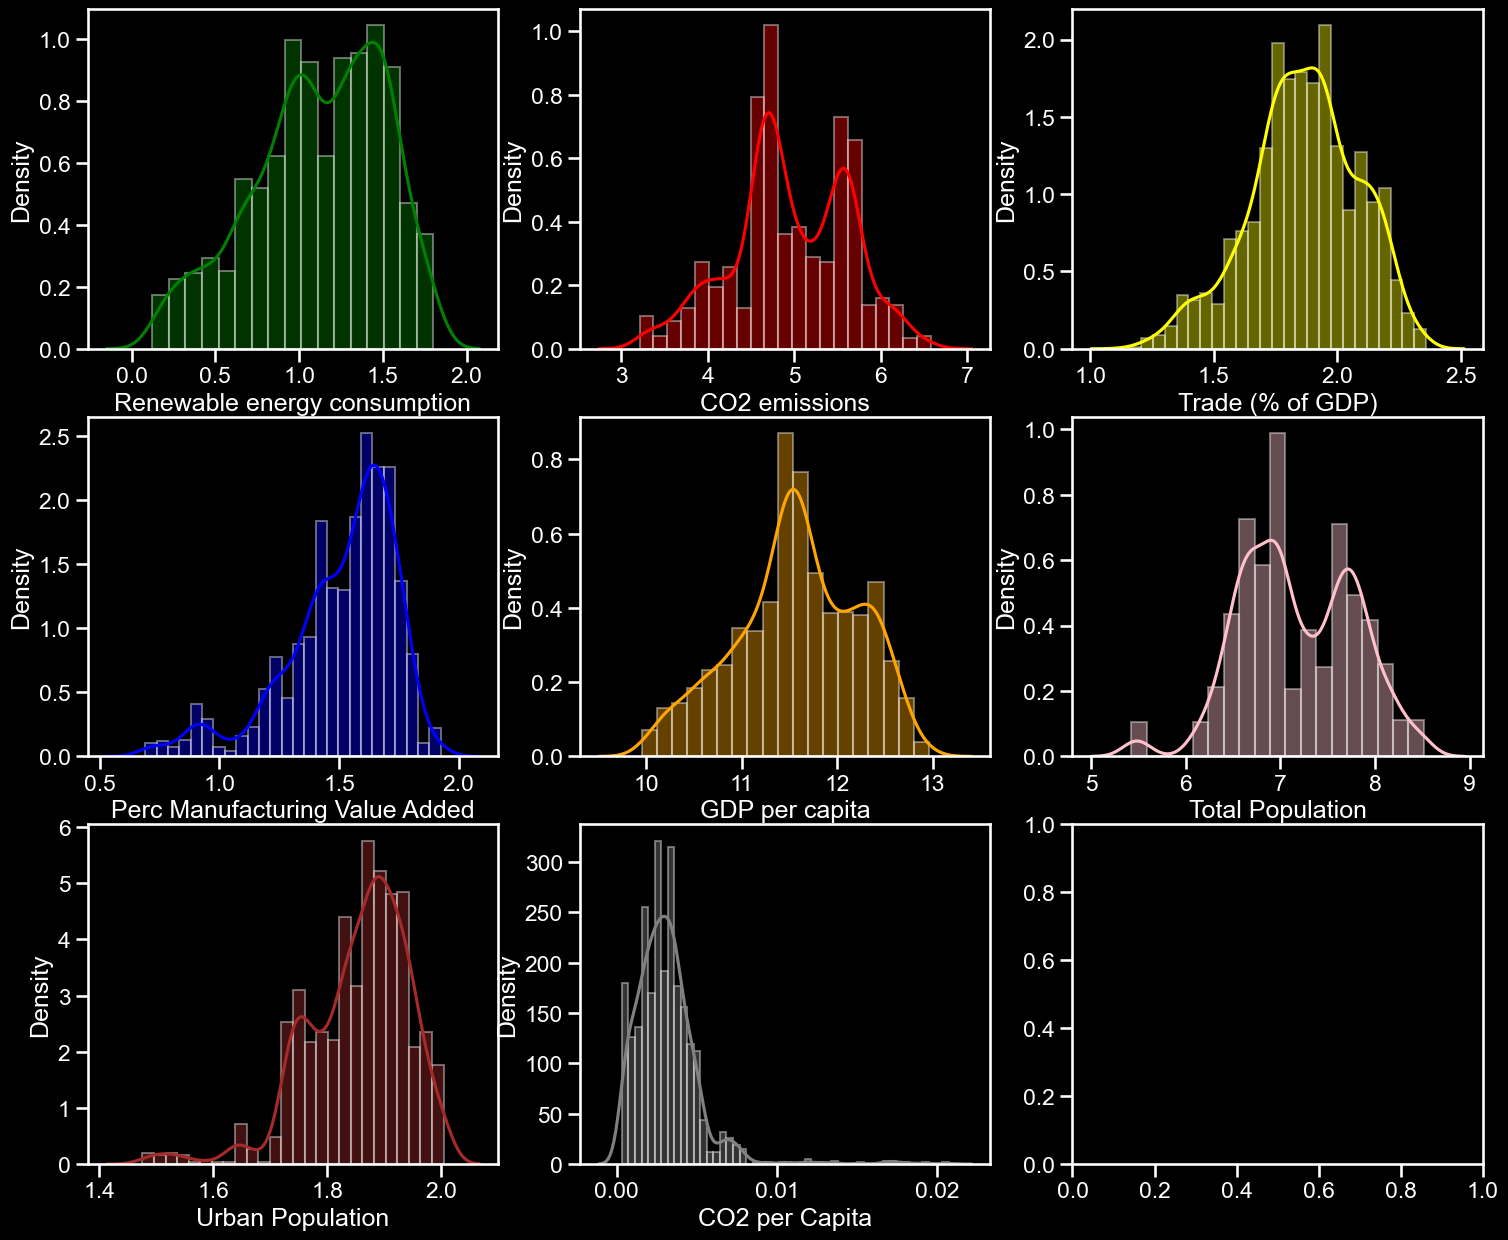

In [21]:
%matplotlib inline

n_rows=3
n_cols=3
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (18,15))

colors = {0:'green',1:'red',2:'yellow',3:'blue',4:'orange',5:'pink',6:'brown',7:'gray'}

for i, column in enumerate(processed_df.columns[2:]):
     seas.distplot(processed_df[column],color= colors[i],ax=axes[i//n_cols,i%n_cols])

### Pair Plots

In [22]:

#seas.pairplot(data=processed_df,  hue='Country',palette="Set1")


In [23]:
#seas.pairplot(data=processed_df,  hue='Time',palette="Set1")


## Data Spliting

In [24]:
X = processed_df[['Renewable energy consumption','Trade (% of GDP)','Perc Manufacturing Value Added','GDP per capita','Urban Population']]
y = processed_df['CO2 per Capita']
  
# using the train test split function
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)


## Modeling

### Mixed Effects Random Forest model.  - `y=f(X)+biZ+e`

* y is the target variable. The current code only supports regression for now, e.g. continuously varying scalar value
* X is the fixed effect features. Assume p dimensional
* f(.) is the nonlinear fixed effects mode, e.g. random forest
* Z is the random effect features. Assume q dimensional.
* e is iid noise ~N(0, sigma_e²)
* i is the cluster index. Assume k clusters in the training.
* bi is the random effect coefficients. They are different per cluster i but are assumed to be drawn from the same distribution ~N(0, Sigma_b) where Sigma_b is learned from the data.

### MERF Package

**Parameters**

* X (np.ndarray) – fixed effect covariates
* Z (np.ndarray) – random effect covariates
* clusters (pd.Series) – cluster assignments for samples
* y (np.ndarray) – response/target variable

A lot of data out there has a clustered structure. The most typical example is longitudinal clustering, which occurs when there are many measurements per individual of a phenomenon to be modeled. Assume we wish to model math test scores as a function of sleep parameters, but each student has many measures. The unique student in this situation is a cluster. We employed the MERF model for this project to predict the CO2 per capita values, clustering the 56 countries we have.

## Hyperparameter Tuning

### We will use 2 techniques for hyperparameter tuning - Random Search and Gird Search. In grid search, we define the combinations and do training of the model, whereas in RandomizedSearchCV the model selects the combinations randomly.

In [25]:
def evaluate(model, X_test, y_train):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_train)
    mape = 100 * np.mean(errors / y_train)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy: {:0.2f}%.'.format(accuracy))
    print('Mean Absolute Percentage Error (MAPE): {:0.2f}'.format(mape))

### RandomizedSearchCV 

In [26]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # <- Number of trees in random forest
max_features = ['auto', 'sqrt'] # <- Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # <-  Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # <- Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # <- Minimum number of samples required at each leaf node
bootstrap = [True, False] # <- Method of selecting samples for training each tree

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### Combinations to try for Hyperparameter Tuning

In [27]:
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [28]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

### Random Search Best Parameters

#### Mean cross-validated score of the best estimator

In [29]:
print ('The best score is : {}%'.format(round(rf_random.best_score_*100.0, 2)))

The best score is : 91.28%


In [30]:
rf_random.best_params_


{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

### Evaluation of base vs best RF Model

#### Base Model Evaluation

In [31]:
base_rf_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_rf_model.fit(X_train, y_train)
base_accuracy = evaluate(base_rf_model, X_test, y_test)

Model Performance
Average Error: 0.0003 degrees.
Accuracy: 87.90%.
Mean Absolute Percentage Error (MAPE): 12.10


#### Best Random Search Model Evaluation

In [32]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.0003 degrees.
Accuracy: 89.53%.
Mean Absolute Percentage Error (MAPE): 10.47


### GridSearchCV

In [33]:
# Create the parameter grid based on the results of random search 
param_grid = {
      'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, None],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [600, 800, 1000, 1200, 1400]
    }

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, return_train_score=True)

In [34]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [80, 90, 100, 110, None],
                         'max_features': [2, 3], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [600, 800, 1000, 1200, 1400]},
             return_train_score=True, verbose=2)

### Gird Search Best Parameters

#### Mean cross-validated score of the best estimator

In [35]:
print ('The best score is : {}%'.format(round(grid_search.best_score_*100.0, 2)))

The best score is : 90.98%


In [36]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

#### Best Grid Search Model Evaluation

In [37]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test) 

Model Performance
Average Error: 0.0003 degrees.
Accuracy: 88.13%.
Mean Absolute Percentage Error (MAPE): 11.87


## Time as Fixed Effect

### Base Model

In [40]:
cv = KFold(n_splits=5, shuffle=True)
mse_base_mrf = []
mape_base_mrf = []
error_base_mrf = []
accuracy_base_mrf = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']

    # Mixed Effects Random Forest Training with 5 vaiables as RE
    base_mrf = MERF()
    X_train =  train[['Time']]
    Z_train = np.array((np.ones(len(X_train)), train['Renewable energy consumption'], 
                                               train['Trade (% of GDP)'],
                                               train['Perc Manufacturing Value Added'],
                                               train['GDP per capita'],
                                               train['Urban Population'])).T
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    base_mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with 5 vaiables as RE
    X_test =  test[['Time']]
    Z_test = np.array((np.ones(len(X_test)),test['Renewable energy consumption'], 
                                               test['Trade (% of GDP)'],
                                               test['Perc Manufacturing Value Added'],
                                               test['GDP per capita'],
                                               test['Urban Population'])).T
    clusters_test = test['Country']
    yhat_mrf = base_mrf.predict(X_test, Z_test, clusters_test)
    mse_base_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

    errors = abs(y - yhat_mrf)
    error_base_mrf.append(errors)    
    mape = 100 * np.mean(errors / yhat_mrf)
    mape_base_mrf.append(mape)
    accuracy = 100 - mape
    accuracy_base_mrf.append(accuracy)

print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(error_base_mrf)))
print('Accuracy = {:0.2f}%.'.format(np.mean(accuracy_base_mrf)))

INFO     [merf.py:307] Training GLL is -3500.8937758564266 at iteration 1.
INFO     [merf.py:307] Training GLL is -6262.505126724234 at iteration 2.
INFO     [merf.py:307] Training GLL is -8753.831257856462 at iteration 3.
INFO     [merf.py:307] Training GLL is -11121.516185638802 at iteration 4.
INFO     [merf.py:307] Training GLL is -13413.885918627893 at iteration 5.
INFO     [merf.py:307] Training GLL is -15631.551659156252 at iteration 6.
INFO     [merf.py:307] Training GLL is -17689.74026522214 at iteration 7.
INFO     [merf.py:307] Training GLL is -19296.81850019127 at iteration 8.
INFO     [merf.py:307] Training GLL is -20143.170826857455 at iteration 9.
INFO     [merf.py:307] Training GLL is -20472.64046042201 at iteration 10.
INFO     [merf.py:307] Training GLL is -20625.396123024417 at iteration 11.
INFO     [merf.py:307] Training GLL is -20715.425555019163 at iteration 12.
INFO     [merf.py:307] Training GLL is -20774.817747968646 at iteration 13.
INFO     [merf.py:307] Tra

Model Performance


TypeError: unsupported format string passed to numpy.ndarray.__format__

## Model 1

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, None],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [600, 800, 1000, 1200, 1400]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)


In [ ]:
cv = KFold(n_splits=5, shuffle=True)
mse_model_1_mrf = []
mape_model_1_mrf = []
error_model_1_mrf = []
accuracy_model_1_mrf = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']

    # Mixed Effects Random Forest Training with 5 vaiables as RE
    model_1_mrf = MERF(fixed_effects_model=GridSearchCV(estimator = rf, param_grid = param_grid, 
                     cv= 2,n_jobs = -1, verbose = 2, return_train_score=True))
    X_train =  train[['Time']]
    Z_train = np.array((np.ones(len(X_train)), train['Renewable energy consumption'], 
                                               train['Trade (% of GDP)'],
                                               train['Perc Manufacturing Value Added'],
                                               train['GDP per capita'],
                                               train['Urban Population'])).T
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    model_1_mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with 5 vaiables as RE
    X_test =  test[['Time']]
    Z_test = np.array((np.ones(len(X_test)),test['Renewable energy consumption'], 
                                               test['Trade (% of GDP)'],
                                               test['Perc Manufacturing Value Added'],
                                               test['GDP per capita'],
                                               test['Urban Population'])).T
    clusters_test = test['Country']
    yha_model_1_mrf = model_1_mrf.predict(X_test, Z_test, clusters_test)
    mse_model_1_mrf.append(np.sqrt(np.sum((y - yha_model_1_mrf)**2)) / len(y))

    errors = abs(y - yha_model_1_mrf)
    error_model_1_mrf.append(mape)    
    mape = 100 * np.mean(errors / yha_model_1_mrf)
    mape_model_1_mrf.append(mape)
    accuracy = 100 - mape
    accuracy_model_1_mrf.append(accuracy)

print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(error_model_1_mrf)))
print('Accuracy = {:0.2f}%.'.format(np.mean(accuracy_model_1_mrf)))


Fitting 2 folds for each of 600 candidates, totalling 1200 fits


INFO     [merf.py:307] Training GLL is -3495.7982919626475 at iteration 1.


Fitting 2 folds for each of 600 candidates, totalling 1200 fits


KeyboardInterrupt: 

In [ ]:
gains = (100 * (mse_df.iloc[0] - mse_df)/ mse_df.iloc[0]).mean(axis=1)
gains = pd.DataFrame(gains)
gains.columns  = ['Gain Value']
gains.reset_index(inplace=True)
gains = gains.rename(columns = {'index':'Model'})

In [ ]:
plt.rcParams["figure.figsize"] = [18, 8]
seas.barplot(x = 'Model',y='Gain Value',data = gains)
plt.xticks(rotation=45)

In [ ]:
viz.plot_merf_training_stats(mrf,num_clusters_to_plot=2)

In [ ]:
plt.rcParams["figure.figsize"] = [18, 8]
mrf.b_hat_history[-1][1].hist()
plt.xticks(rotation=45)